In [94]:
from encoder_model import EncoderDNN
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score
import torch as torch

import data_helper_413 as DataHelper
import model_413 as Model

os.environ["CUDA_VISIBLE_DEVICES"]='0'
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.9
set_session(tf.Session(config=config))


base_dir= os.getcwd()
test_csv_path=os.path.join(base_dir,'/home/aries/413/CNNLoc-Access/TestData.csv')
valid_csv_path=os.path.join(base_dir,'/home/aries/413/CNNLoc-Access/ValuationData.csv')
train_csv_path=os.path.join(base_dir,'/home/aries/413/CNNLoc-Access/TrainingData.csv')

In [144]:
(train_x, train_y), (valid_x, valid_y),(test_x,test_y) = DataHelper.load_data_all(train_csv_path, valid_csv_path,test_csv_path)
# (train_x,train_y) = Model.filter_building(train_x,train_y,1)
# (valid_x, valid_y) = Model.filter_building(valid_x, valid_y,1)
nn_model = Model.NN()
nn_model._preprocess(train_x,train_y,valid_x,valid_y)

In [142]:
def preprocess_data(data):
    # Initialize lists to store the preprocessed indices and signal strengths
    preprocessed_indices = []
    preprocessed_strengths = []

    # Iterate over each sample in the batch
    for sample in data:
        # Find the indices and values of non-zero signal strengths
        non_zero_indices = np.nonzero(sample)[0]
        non_zero_values = sample[non_zero_indices]

        # Sort the indices by signal strength in descending order
        sorted_indices = non_zero_indices[np.argsort(-non_zero_values)]
        sorted_values = non_zero_values[np.argsort(-non_zero_values)]

        # Append the sorted indices and values to the preprocessed data
        preprocessed_indices.append(sorted_indices)
        preprocessed_strengths.append(sorted_values)

    # Determine the maximum number of non-zero values in a sample
    M = max(len(indices) for indices in preprocessed_indices)

    # Pad each list of indices and signal strengths to have the same length
    for i in range(len(preprocessed_indices)):
        padding = M - len(preprocessed_indices[i])
        preprocessed_indices[i] = np.pad(preprocessed_indices[i], (0, padding), 'constant')
        preprocessed_strengths[i] = np.pad(preprocessed_strengths[i], (0, padding), 'constant')

    # Stack the preprocessed data to form the final output
    preprocessed_indices = np.stack(preprocessed_indices)
    preprocessed_strengths = np.stack(preprocessed_strengths)

    return preprocessed_indices, preprocessed_strengths

In [145]:
from torch.nn.init import xavier_uniform_

class LocalizationModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, output_dim):
        super(LocalizationModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        xavier_uniform_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # x is of shape (batch_size, M), where M is the maximum number of non-zero signal strengths in a sample
        # signal_strengths is of shape (batch_size, M), corresponding to the signal strengths of the WAPs in x

        # Embed the WAP indices
        x = self.embedding(x)  # shape: (batch_size, M, embedding_dim)

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

        # Sum across the signal strength dimension to get a single vector for each sample
        x = x.sum(dim=1)  # shape: (batch_size, embedding_dim)

        # Pass through the first fully connected layer
        x = self.fc1(x)  # shape: (batch_size, hidden_dim)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Pass through the second fully connected layer to get the output
        out = self.fc2(x)  # shape: (batch_size, output_dim)

        return out

In [146]:
model = LocalizationModel(num_waps=520, embedding_dim=50, output_dim=2)

from torch.nn.functional import cosine_similarity

# Get the embeddings for WAPs 0 and 1
embedding_0 = model.embedding.weight.data[0]
embedding_1 = model.embedding.weight.data[1]

print(embedding_0)

# Compute the cosine similarity
similarity = cosine_similarity(embedding_0, embedding_1, dim=0)

print(similarity)

TypeError: __init__() missing 1 required positional argument: 'hidden_dim'

In [147]:
from torch.utils.data import TensorDataset, DataLoader

print(nn_model.normalize_valid_x[0].max())

# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x)
pre_y = nn_model.floorID_y
pre_valid_y = nn_model.floorID_valid_y

print(pre_x[1])
print(pre_strengths[1])

# Convert the datasets to PyTorch tensors
pre_x = torch.tensor(pre_x, dtype=torch.long)
pre_strengths = torch.tensor(pre_strengths, dtype=torch.float32)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
pre_y = torch.tensor(pre_y, dtype=torch.long)
pre_valid_y = torch.tensor(pre_valid_y, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(pre_x, pre_strengths, pre_y)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

0.04346970049526747
[171 172  89  90 191 190 102 103 104 105 167 168  45   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[8.87445887e-02 8.26713072e-02 2.95251726e-02 2.95251726e-02
 1.27425954e-02 9.48717517e-03 5.69415691e-03 5.69415691e-03
 1.82967479e-03 9.79548331e-04 6.73982185e-04 2.62718053e-04
 2.89983913e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

Epoch: 1, Train Loss: 0.6454, Train Acc: 0.8202, Val Loss: 0.2411, Val Acc: 0.9536
Epoch: 2, Train Loss: 0.1595, Train Acc: 0.9703, Val Loss: 0.1745, Val Acc: 0.9644
Epoch: 3, Train Loss: 0.1164, Train Acc: 0.9747, Val Loss: 0.1500, Val Acc: 0.9662
Epoch: 4, Train Loss: 0.0942, Train Acc: 0.9782, Val Loss: 0.1278, Val Acc: 0.9705
Epoch: 5, Train Loss: 0.0787, Train Acc: 0.9794, Val Loss: 0.1221, Val Acc: 0.9672
Epoch: 6, Train Loss: 0.0687, Train Acc: 0.9825, Val Loss: 0.1145, Val Acc: 0.9705
Epoch: 7, Train Loss: 0.0605, Train Acc: 0.9832, Val Loss: 0.1089, Val Acc: 0.9733
Epoch: 8, Train Loss: 0.0546, Train Acc: 0.9844, Val Loss: 0.1042, Val Acc: 0.9719
Epoch: 9, Train Loss: 0.0505, Train Acc: 0.9858, Val Loss: 0.1033, Val Acc: 0.9756
Epoch: 10, Train Loss: 0.0442, Train Acc: 0.9868, Val Loss: 0.0980, Val Acc: 0.9751


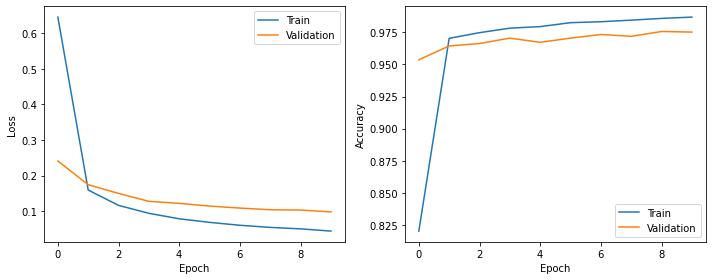

(LocalizationModel(
   (embedding): Embedding(520, 150)
   (fc1): Linear(in_features=150, out_features=200, bias=True)
   (fc2): Linear(in_features=200, out_features=5, bias=True)
 ),
 [0.6454191432475186,
  0.1595162909960361,
  0.1164481832960741,
  0.09417708075384228,
  0.07872280351593153,
  0.06869603071710188,
  0.06050994074920179,
  0.054568904897586694,
  0.050475899812685014,
  0.04417340662631896],
 [0.24111602055456707,
  0.17448768344269516,
  0.1500349164741826,
  0.12775988540242372,
  0.1221267968417926,
  0.1144939127852387,
  0.10887149457052789,
  0.1041795282257868,
  0.10329712942626322,
  0.09804527090551239],
 [0.8202266193133773,
  0.970291448221433,
  0.974688539376515,
  0.9781836631151699,
  0.9794238683127572,
  0.9824680083431986,
  0.9832008568690456,
  0.9844410620666328,
  0.9857940131912735,
  0.9868087265347539],
 [0.9535647279549718,
  0.9643527204502814,
  0.9662288930581614,
  0.9704502814258912,
  0.9671669793621013,
  0.9704502814258912,
  0.9732

In [148]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else



def train_model(model, num_epochs, learning_rate):

    # Define the loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, signal_strengths, targets) in enumerate(train_loader):
            inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, signal_strengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, signal_strengths, targets) in enumerate(val_loader):
                inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

                outputs = model(inputs, signal_strengths)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs
    
# Create the model
embedding_dim = 150
hidden_dim = 200
num_classes = 5

model = LocalizationModel(520, embedding_dim, hidden_dim, num_classes).to(device)
train_model(model, num_epochs=10, learning_rate=0.001)


In [149]:
embedding_43 = model.embedding.weight.data[42]
embedding_44 = model.embedding.weight.data[43]
embedding_1 = model.embedding.weight.data[1]

# print(embedding_1)

# Compute the cosine similarity
similarity1 = cosine_similarity(embedding_43, embedding_44, dim=0)
similarity2 = cosine_similarity(embedding_43, embedding_1, dim=0)
print(similarity1)
print(similarity2)


def print_top_five_similar_waps(model):
    # Get the embeddings from the model
    embeddings = model.embedding.weight.data

    # Iterate over each WAP
    for i in range(embeddings.shape[0]):
        # Compute the cosine similarity with all other WAPs
        similarities = cosine_similarity(embeddings[i].unsqueeze(0), embeddings)

        # Get the indices of the top five most similar WAPs
        top_five_indices = similarities.topk(6)[1]

        # Remove the WAP itself from the list
        top_five_indices = top_five_indices[top_five_indices != i]

        # Print the WAP and its top five most similar WAPs
        print(f'WAP {i+1}:', ', '.join(f'WAP {j+1} (similarity: {similarities[j]:.4f})' for j in top_five_indices))

print_top_five_similar_waps(model)

tensor(0.8746)
tensor(-0.0386)
WAP 1: WAP 89 (similarity: 0.2476), WAP 27 (similarity: 0.1957), WAP 339 (similarity: 0.1832), WAP 216 (similarity: 0.1761), WAP 224 (similarity: 0.1749)
WAP 2: WAP 91 (similarity: 0.6446), WAP 23 (similarity: 0.6334), WAP 380 (similarity: 0.6318), WAP 24 (similarity: 0.6302), WAP 171 (similarity: 0.6296)
WAP 3: WAP 423 (similarity: 0.2192), WAP 379 (similarity: 0.1886), WAP 276 (similarity: 0.1730), WAP 88 (similarity: 0.1591), WAP 488 (similarity: 0.1413)
WAP 4: WAP 157 (similarity: 0.1922), WAP 239 (similarity: 0.1810), WAP 485 (similarity: 0.1663), WAP 150 (similarity: 0.1643), WAP 241 (similarity: 0.1514)
WAP 5: WAP 145 (similarity: 0.8952), WAP 139 (similarity: 0.8569), WAP 436 (similarity: 0.8567), WAP 435 (similarity: 0.8410), WAP 218 (similarity: 0.8399)
WAP 6: WAP 141 (similarity: 0.9482), WAP 60 (similarity: 0.9472), WAP 140 (similarity: 0.9363), WAP 204 (similarity: 0.9270), WAP 67 (similarity: 0.9269)
WAP 7: WAP 126 (similarity: 0.8892), WAP 